In [1]:
import matplotlib.pyplot as plt
import numpy as np
from imageio.v2 import imread
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from skimage.color import rgba2rgb, rgb2gray
from skimage.util import img_as_float

In [2]:
img_file = "data/original_frame_225.png"

In [3]:
img = imread(img_file)  # image was originally saved as RGBA (?)
img = rgb2gray(rgba2rgb(img))  # convert image to grayscale
img = img_as_float(img)  # ensure image is in 0-1 range
print(img.dtype, img.shape)

float64 (2560, 2160)


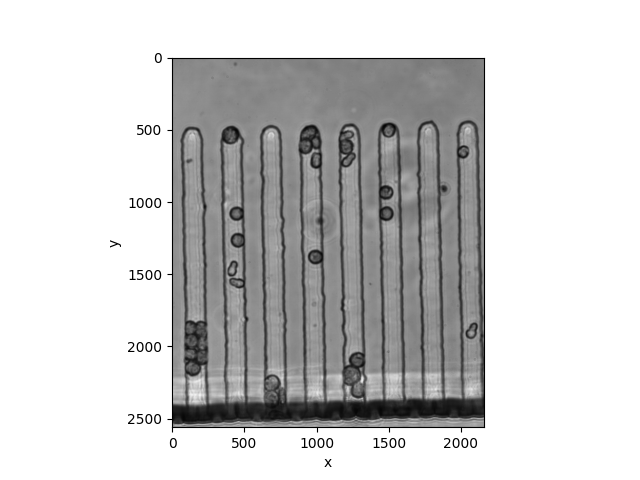

In [4]:
%matplotlib widget
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [5]:
# in case of co-registered time-resolved data, also (max-)project along time axis
inv_aip = 1 - np.mean(img, axis=0)  # inverted average intensity projection (AIP)

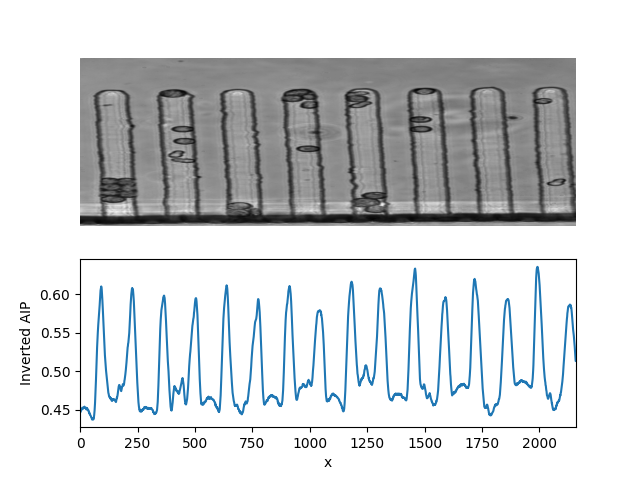

In [6]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(img, cmap="gray", aspect="auto")
ax1.set_axis_off()
ax2.plot(inv_aip)
ax2.set_xlabel("x")
ax2.set_ylabel("Inverted AIP")
plt.show()

In [7]:
min_trap_width = 100
max_trap_width = 150

In [8]:
# fourier analysis
fourier = rfft(inv_aip)
freqs = rfftfreq(inv_aip.size)
magnitudes = np.abs(fourier)
# filter frequency peaks
min_freq = 1 / max_trap_width
max_freq = 1 / min_trap_width
freq_filter = (freqs >= min_freq) & (freqs <= max_freq)
filtered_freqs = freqs[freq_filter]
filtered_magnitudes = magnitudes[freq_filter]
# find highest peak within range --> trap width
max_magnitude_idx = np.argmax(filtered_magnitudes)
trap_width_freq = filtered_freqs[max_magnitude_idx]
trap_width = int(1 / trap_width_freq)
print(trap_width)

135


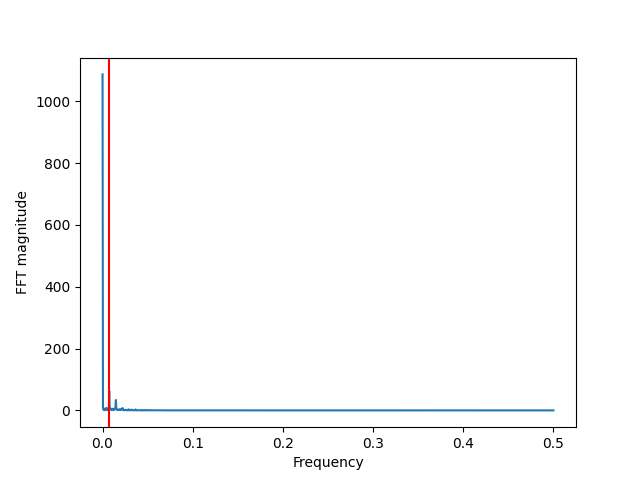

In [9]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(freqs, magnitudes)
ax.axvline(trap_width_freq, color="red")
ax.set_xlabel("Frequency")
ax.set_ylabel("FFT magnitude")
plt.show()

In [10]:
# 1D filtering with "trap width-kernel"
ys = inv_aip[:-trap_width] + inv_aip[trap_width:]
xs = 0.5 * trap_width + np.arange(len(ys))
# find peaks --> trap centers
peaks, _ = find_peaks(ys, distance=0.8 * trap_width)
peaks = peaks[::2]  # only if trap spacing = trap width!
trap_centers = xs[peaks]
len(trap_centers)

8

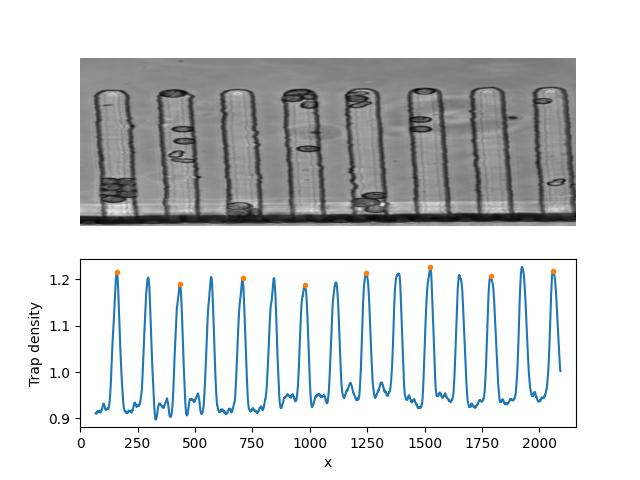

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(img, cmap="gray", aspect="auto")
ax1.set_axis_off()
ax2.plot(xs, ys)
ax2.plot(trap_centers, ys[peaks], ".")
ax2.set_xlabel("x")
ax2.set_ylabel("Trap density")
plt.show()

In [12]:
margin = 50

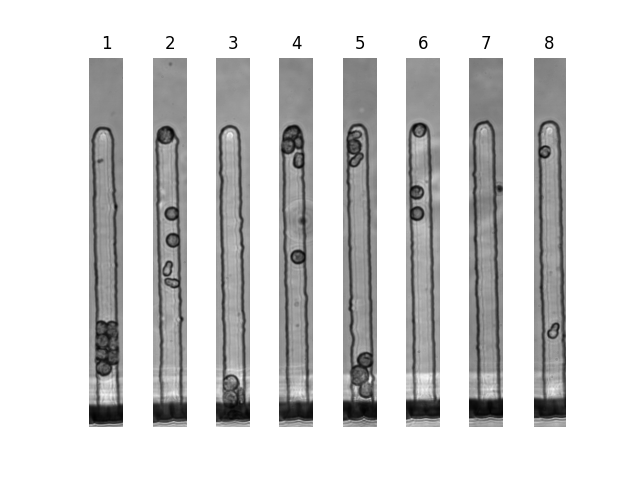

In [13]:
fig, axs = plt.subplots(ncols=len(trap_centers))
for i, (ax, trap_center) in enumerate(zip(axs, trap_centers)):
    trap_start = max(0, int(np.floor(trap_center - 0.5 * trap_width)) - margin)
    trap_end = min(img.shape[-1], int(np.ceil(trap_center + 0.5 * trap_width)) + margin)
    trap_img = img[:, trap_start:trap_end]
    ax.imshow(trap_img, cmap="gray")
    ax.set_axis_off()
    ax.set_title(i + 1)